<a href="https://colab.research.google.com/github/cuberhaus/MD2/blob/main/src/meta_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, ParameterGrid, train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
from scipy.stats import mode
import numpy as np
from dataLoader import *

# Majority Vote Role

In [2]:
import matplotlib.pyplot as plt

def majority_vote_role(pre_trained_models_array, X_test, y_test):

  height = [0,0]
  bars = ('Same', 'Difference')
  y_pos = np.arange(len(bars))

  predictions = []
  for model in pre_trained_models_array:
    predictions.append(model.predict(X_test))
  
  predictions = np.array(predictions)
  final_prediction = (mode(predictions.T, axis=-1, keepdims=True)[0]).T[0]

  for in_line_prediction in predictions.T:
    if len(set(in_line_prediction)) > 1:
      height[1] = height[1] + 1
    else:
      height[0] = height[0] + 1


  accuracy = 0
  for predicted_y, y in zip(final_prediction, y_test):

    if predicted_y == y :
      accuracy += 1

  
    # Create bars
  plt.bar(y_pos, height)

  # Create names on the x-axis
  plt.xticks(y_pos, bars)

  # Show graphic
  plt.show()

  return accuracy / len(y_test)


In [3]:
results_df_user = pd.DataFrame()
X_train, X_test, y_train, y_test = get_user_test_traingi_set(0.20)


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=20)
test_model_and_save_result(decision_tree, "Decision_tree", X_train, X_test, y_train, y_test, results_df_user)
results_df_user.sort_values(by=['acc'], ascending=False)

,acc,prec,recall,test f1 score (W)
Decision_tree,0.90096,0.899608,0.90096,0.833709


In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

results_df_mvr = pd.DataFrame()

knn = KNeighborsClassifier(n_neighbors=1)

test_model_and_save_result(knn, "KNN", X_train, X_test, y_train, y_test, results_df_mvr)

dr1 = DecisionTreeClassifier(max_depth=20, random_state=10)
test_model_and_save_result(dr1, "Decision_tree1", X_train[:len(y_train)//2], X_test, y_train[:len(y_train)//2], y_test, results_df_mvr)

dr2 = DecisionTreeClassifier(max_depth=30, random_state=25)
test_model_and_save_result(dr2, "Decision_tree2", X_train[len(y_train)//2:], X_test, y_train[len(y_train)//2:], y_test, results_df_mvr)


results_df_mvr.sort_values(by=['acc'], ascending=False)

,acc,prec,recall,test f1 score (W)
Decision_tree2,0.869206,0.868029,0.869206,0.796537
KNN,0.864661,0.863969,0.864661,0.796469
Decision_tree1,0.862100,0.860431,0.862100,0.778553


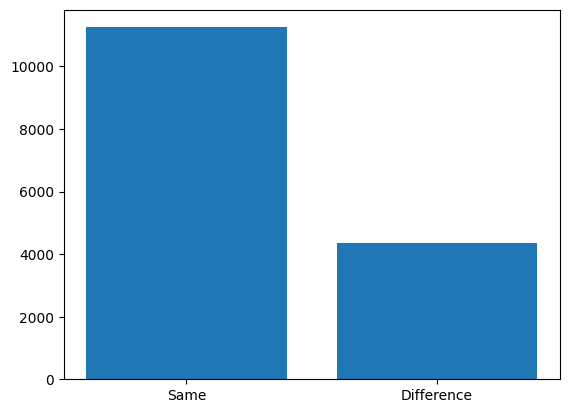

0.9241997439180538


In [6]:
from sklearn.ensemble import VotingClassifier

print(majority_vote_role([knn, dr1,dr2], X_test, y_test))


vc = VotingClassifier(estimators=[('KNN', knn), ('Decision_tree1', dr1), ('Decision_tree2', dr2)], voting='soft')

test_model_and_save_result(vc, "majority_vote_role", X_train, X_test, y_train, y_test, results_df_user)

# Bagging

In [7]:
from sklearn.ensemble import BaggingClassifier
estimator_range = [2,4,6,10,20,30]

models = []
scores = []

for n_estimators in estimator_range:

    # Create bagging classifier
    clf = BaggingClassifier(n_estimators = n_estimators, random_state = 22, n_jobs=-1)

    # Fit the model
    clf.fit(X_train, y_train)

    # Append the model and score to their respective list
    models.append(clf)
    scores.append(accuracy_score(y_true = y_test, y_pred = clf.predict(X_test)))


In [8]:
test_model_and_save_result(clf, "Bagging Classifier", X_train, X_test, y_train, y_test, results_df_user)

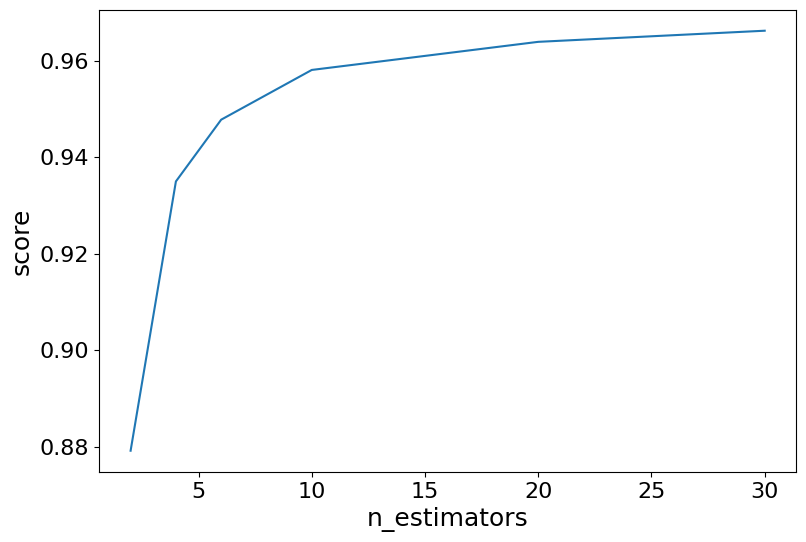

In [9]:
import matplotlib.pyplot as plt

# Generate the plot of scores against number of estimators
plt.figure(figsize=(9,6))
plt.plot(estimator_range, scores)

# Adjust labels and font (to make visable)
plt.xlabel("n_estimators", fontsize = 18)
plt.ylabel("score", fontsize = 18)
plt.tick_params(labelsize = 16)

# Visualize plot
plt.show()

# RandomForest

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
rf = RandomForestClassifier(max_depth=200, max_features=4, n_estimators=200, n_jobs=-1)
test_model_and_save_result(rf, "Random Forest", X_train, X_test, y_train, y_test, results_df_user)

In [12]:
results_df_user.sort_values(by=['acc'], ascending=False)

,acc,prec,recall,test f1 score (W)
Random Forest,0.982714,0.982614,0.982714,0.926240
Bagging Classifier,0.966197,0.965651,0.966197,0.915705
majority_vote_role,0.917990,0.917158,0.917990,0.857498
Decision_tree,0.900960,0.899608,0.900960,0.833709


# Adaboost

In [13]:
from sklearn.ensemble import AdaBoostClassifier
ABC = AdaBoostClassifier(n_estimators=200,
                         estimator = decision_tree,
                         learning_rate=1, 
                         random_state=23)
test_model_and_save_result(ABC, "AdaBoost", X_train, X_test, y_train, y_test, results_df_user)

In [14]:
results_df_user.sort_values(by=['acc'], ascending=False)

,acc,prec,recall,test f1 score (W)
AdaBoost,0.989757,0.989702,0.989757,0.950960
Random Forest,0.982714,0.982614,0.982714,0.926240
Bagging Classifier,0.966197,0.965651,0.966197,0.915705
majority_vote_role,0.917990,0.917158,0.917990,0.857498
Decision_tree,0.900960,0.899608,0.900960,0.833709


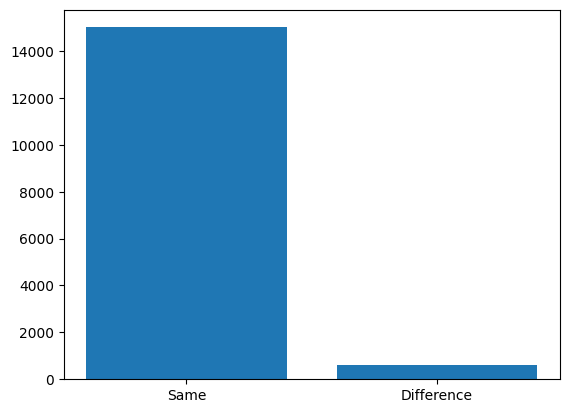

0.9874519846350832


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [15]:
print(majority_vote_role([ABC, rf,clf], X_test, y_test))


vc = VotingClassifier(estimators=[('ABC', ABC), ('rf', rf), ('Bagging Classifier', clf)], voting='soft', n_jobs=-1)

test_model_and_save_result(vc, "majority_vote_role 2", X_train, X_test, y_train, y_test, results_df_user)

In [16]:
results_df_user.sort_values(by=['acc'], ascending=False)

,acc,prec,recall,test f1 score (W)
majority_vote_role 2,0.989821,0.989856,0.989821,0.949099
AdaBoost,0.989757,0.989702,0.989757,0.950960
Random Forest,0.982714,0.982614,0.982714,0.926240
Bagging Classifier,0.966197,0.965651,0.966197,0.915705
majority_vote_role,0.917990,0.917158,0.917990,0.857498
Decision_tree,0.900960,0.899608,0.900960,0.833709
